<a href="https://colab.research.google.com/github/jgarvey928/Books/blob/master/Job_Scapper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!pip install selenium nltk

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import StaleElementReferenceException, TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
import pandas as pd
import random
import csv
import re
import time
import io

# Ensure you have the necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [2]:
# Prompt the user for input and store it in the variables
# website_link = "https://www.linkedin.com/jobs/search?keywords=Software%20Engineer&location=Boston&geoId=102380872&distance=25&f_E=2&f_TPR=&f_WT=1%2C3&f_JT=F%2CP%2CI&position=1&pageNum=0"
# name_files = "sd2_bst_entry_onsite_month_04_30_25"
# max_listings = 80
wait_seconds = 1

website_link = input("Enter the website link: ")
name_files = input("Enter the name for the output files: ")
max_listings = int(input("Enter the maximum number of listings to scrape (as a number): "))
# wait_seconds = int(input("Enter the wait time in seconds (as a number): "))


Enter the website link: https://www.linkedin.com/jobs/search?keywords=Software%20Engineer&location=Boston&geoId=102380872&distance=25&f_E=2&f_TPR=&f_WT=1%2C3&f_JT=F%2CP%2CI&position=1&pageNum=0
Enter the name for the output files: 80
Enter the maximum number of listings to scrape (as a number): 80


In [3]:
my_df = pd.DataFrame()

def scrape_data(name_file, website_link, post_limit):
    """Scrapes job data from LinkedIn and saves it to a CSV file.

    Args:
        name_file (str): The name of the CSV file.
        website_link (str): The URL of the LinkedIn job search page.
        post_limit (int): The maximum number of job postings to scrape.
    """
    # Initialize WebDriver with headless option
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--disable-dev-shm-usage")
    driver = webdriver.Chrome(options=chrome_options)
    driver.get(website_link)
    # Send Escape Key Press to Clear Any Pop Ups
    webdriver.ActionChains(driver).send_keys(Keys.ESCAPE).perform()

    job_data = []  # Initialize an empty list to store job data
    count = 0

    while count < post_limit:
        job_listings = driver.find_elements(By.XPATH, '//*[@id="main-content"]/section[2]/ul/li')
        if not job_listings or count >= len(job_listings):  # Break if no more listings
            break

        try:
            listing = job_listings[count]
            job_title = listing.find_element(By.CLASS_NAME, 'base-search-card__title').text
            company = listing.find_element(By.CLASS_NAME, 'base-search-card__subtitle').text
            address = listing.find_element(By.CLASS_NAME, 'job-search-card__location').text
            date = listing.find_element(By.XPATH, '//*[starts-with(@class, "job-search-card__listdate")]').text
            job_link = listing.find_element(By.CLASS_NAME, 'base-card__full-link').get_attribute('href')

            # Open job details in a new tab
            driver.execute_script("window.open('');")
            driver.switch_to.window(driver.window_handles[-1])
            driver.get(job_link)
            webdriver.ActionChains(driver).send_keys(Keys.ESCAPE).perform()

            # Wait for the element to load (adjust the time if necessary)
            time.sleep(wait_seconds)

            # description_element = WebDriverWait(driver, 10).until(
            #       EC.presence_of_element_located((By.XPATH, '//*[@class="core-section-container__content break-words"]'))
            #   )

            job_description = driver.find_element(By.XPATH, '//*[@id="main-content"]/section[1]')
            description_element = job_description.find_element(By.XPATH, '//*[@class="core-section-container__content break-words"]')

            description_html = description_element.get_attribute('innerHTML')
            pretty_html = BeautifulSoup(description_html, 'html.parser').prettify()

            job_data.append([job_title, company, date, address, job_link, pretty_html])

            # Close current tab and switch back to main window
            driver.close()
            driver.switch_to.window(driver.window_handles[0])

        except StaleElementReferenceException:
            print("StaleElementReferenceException occurred. Retrying...")
            continue  # Skip to the next iteration and try again
        except TimeoutException:
            print("TimeoutException occurred. Element not found. Skipping this job.")
            continue  # Skip to the next iteration and try again
        finally:
            count += 1

    driver.quit()

    df = pd.DataFrame(job_data, columns=["Job Title", "Company", "Date", "Address", "Link", "Description"])
    df.drop_duplicates(subset=["Job Title", "Company"], keep="first", inplace=True)
    my_df = df
    df.to_csv(name_file + '.csv', index=False, encoding='utf-8')
    print(f"Data saved to Files/{name_file}.csv")

scrape_data(name_files, website_link, max_listings)

In [9]:

# List of keywords to identify the requirements section
keywords = [
    "requirements", "requirement", "qualifications", "qualification", "required education and experience",
    "skills/qualifications", "skills/qualification", "must have", "required skills", "desired skills",
    "preferred qualifications", "preferred qualification", "basic qualifications", "basic qualification",
    "essential skills", "essential skill", "job requirements", "job requirement", "job qualifications",
    "job qualification", "required experience", "preferred experience", "required education", "desired qualifications",
    "desired qualification", "experience", "education", "skills", "skill", "must-have", "must haves", "must-have skills",
    "must-have skill", "required", "preferred", "essential", "basic", "necessary", "mandatory", "needed", "desired",
    "Who Should Apply", "What We're Looking For", "What You'll Do", "What You'll Need",
    "What You'll Bring", "What You'll Be Doing", "What You'll Be Responsible For", "What do you need to have",
    "What Do You Need To Bring", "What You'll Need To Bring", "What You'll Need To Have", "What You'll Need To Do",
    "you'll use", "Nice To Have"
]

# Compile a regular expression pattern to match any of the keywords
keywords_pattern = re.compile('|'.join([re.escape(keyword) for keyword in keywords]), re.IGNORECASE)

all_requirements = []

# Function to check if a string contains any of the keywords
def contains_keywords(text):
    return bool(keywords_pattern.search(text))

def not_single_word(text):
    return ' ' in text

def clean_html(description):
    soup = BeautifulSoup(description, 'html.parser')
    text = soup.get_text(separator="\n")
    # Remove leading/trailing whitespaces and empty lines
    cleaned_text = "\n".join([line.strip() for line in text.splitlines() if line.strip()])
    return cleaned_text

def extract_csv(df):
    modified_rows = []
    fieldnames = df.columns.tolist() + ['Cleaned'] + ['Requirements']

    for index, row in df.iterrows():
        collected_text = []

        collected_text.append(row['Job Title'])
        collected_text.append(row['Company'])

        description = row['Description']
        soup = BeautifulSoup(description, 'html.parser')

        strong_elements = soup.find_all('strong')
        i = 0
        for strong in strong_elements:
            if contains_keywords(strong.get_text(strip=True)):
                i += 1
                collected_text.append("\n" + str(i) + "\n")
                collected_text.append(strong.get_text(strip=True))

                for sibling in strong.next_siblings:
                    if sibling.name == 'strong':
                        break
                    if sibling.name in ['p', 'ul', 'li', 'br', 'span']:
                        text1 = sibling.get_text(strip=True)
                        if text1:
                            collected_text.append(text1)
                    elif isinstance(sibling, str):
                        text2 = sibling.strip()
                        if text2:
                            collected_text.append(text2)
                    elif sibling.name is None:
                        text3 = sibling.strip()
                        if text3:
                            collected_text.append(text3)

                for sibling in strong.find_all_next():
                    if sibling.name == 'strong':
                        break
                    if sibling.name in ['p', 'ul', 'li', 'br', 'span']:
                        text1 = sibling.get_text(strip=True)
                        if text1:
                            collected_text.append(text1)
                    elif isinstance(sibling, str):
                        text2 = sibling.strip()
                        if text2:
                            collected_text.append(text2)

        li_elements = soup.find_all('li')
        for li in li_elements:
            collected_text.append(li.get_text(strip=True))

        span_elements = soup.find_all('span')
        for span in span_elements:
            collected_text.append(span.get_text(strip=True))

        collected_text.append("\n__________________________________________________\n")

        seen = set()
        unique_collected_text = []
        for section in collected_text:
            if section not in seen:
                unique_collected_text.append(section)
                seen.add(section)

        index = 0
        while index < len(unique_collected_text):
            if (index + 2) < len(unique_collected_text):
                if unique_collected_text[index + 1] in unique_collected_text[index] and not_single_word(unique_collected_text[index + 1]):
                    pass
                elif unique_collected_text[index + 2] in unique_collected_text[index] and not_single_word(unique_collected_text[index + 2]):
                    pass
                else:
                    all_requirements.append(unique_collected_text[index])
            else:
                all_requirements.append(unique_collected_text[index])
            index += 1

        row_dict = row.to_dict()
        row_dict['Cleaned'] = clean_html(row_dict['Description'])
        row_dict['Requirements'] = "".join(unique_collected_text)
        modified_rows.append(row_dict)

    modified_df = pd.DataFrame(modified_rows)
    return modified_df

def download_data(name_file, df):
    modified_df = extract_csv(df)
    modified_df.to_csv(name_file + '.csv', index=False, encoding='utf-8')

    requirements = all_requirements
    requirements = [req for req in requirements if req.strip()]

    with open(name_file + '_reqs.txt', 'w', encoding='utf-8') as file:
        for req in requirements:
            print("+ " + req)
            file.write(req + "\n")

df = pd.read_csv(name_files+'.csv')
download_data(name_files, df)

+ Software Development Engineer - Recent Grads Welcome
+ Sonos, Inc.
+ 
1

+ Preferred Qualifications
+ Research shows that
+ Experience developing software that leverages common AWS components (ex. ElasticCache, RDS, EC2, Lambda, cloud networking, etc…)
+ Ability and experience to leverage data and metrics to define service health and performance and exposure to toolstacks in this space
+ Hands-on experience developing and deploying services that leverage containers and Kubernetes
+ Prior project experience that involves one or more of the following: connected devices at scale, software authentication and authorization, REST-based web services, data modeling in SQL and NoSQL, search engines, data pipelines.
+ Design and develop cloud-based software solutions that are directly used by our customers’ systems, as well as both Sonos-internal and our partner services and systems
+ Participate in all aspects of the software development life cycle including planning, requirements, developmen

['recent', 'grad', 'welcomesonos', 'inc.', 'qualificationsexperience', 'leverage', 'common', 'aws', 'component', 'ex', 'elasticcache', 'rds', 'ec2', 'lambda', 'cloud', 'networking', 'etc…', 'leverage', 'metric', 'define', 'exposure', 'toolstacks', 'spacehands-on', 'deploying', 'leverage', 'container', 'kubernetesprior', 'involve', 'following', 'connected', 'device', 'scale', 'authentication', 'authorization', 'rest-based', 'modeling', 'sql', 'nosql', 'search', 'engine', 'pipelines.research', 'show', 'thatexperience', 'leverage', 'common', 'aws', 'component', 'ex', 'elasticcache', 'rds', 'ec2', 'lambda', 'cloud', 'networking', 'etc…', 'leverage', 'metric', 'define', 'exposure', 'toolstacks', 'spacehands-on', 'deploying', 'leverage', 'container', 'kubernetesprior', 'involve', 'following', 'connected', 'device', 'scale', 'authentication', 'authorization', 'rest-based', 'modeling', 'sql', 'nosql', 'search', 'engine', 'pipelines.design', 'cloud-based', 'directly', 'sonos-internal', 'systems

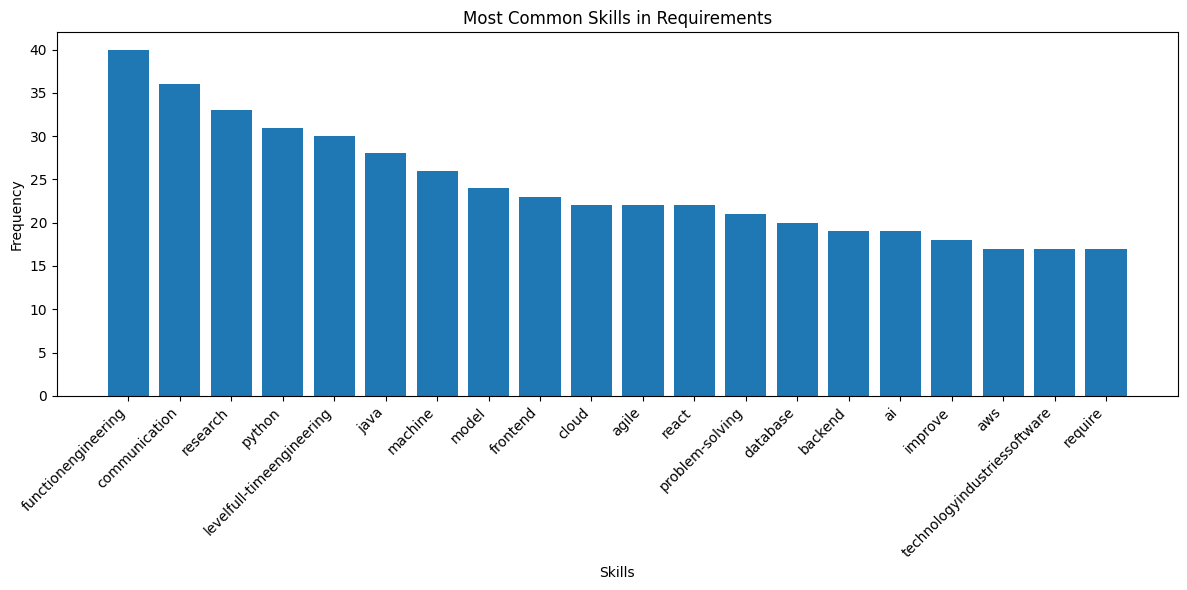

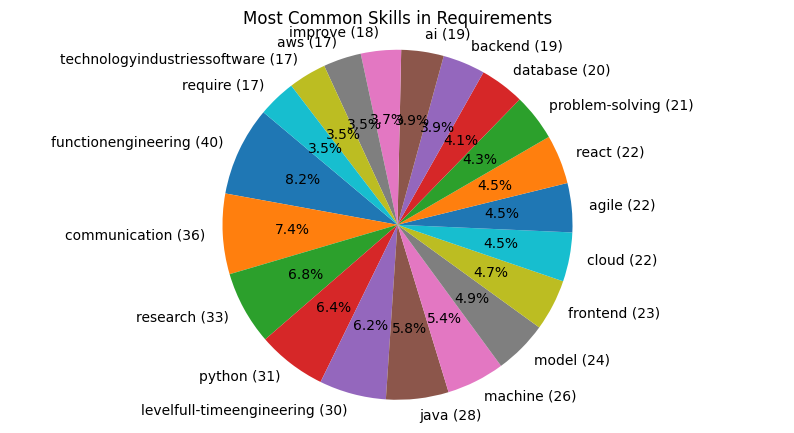

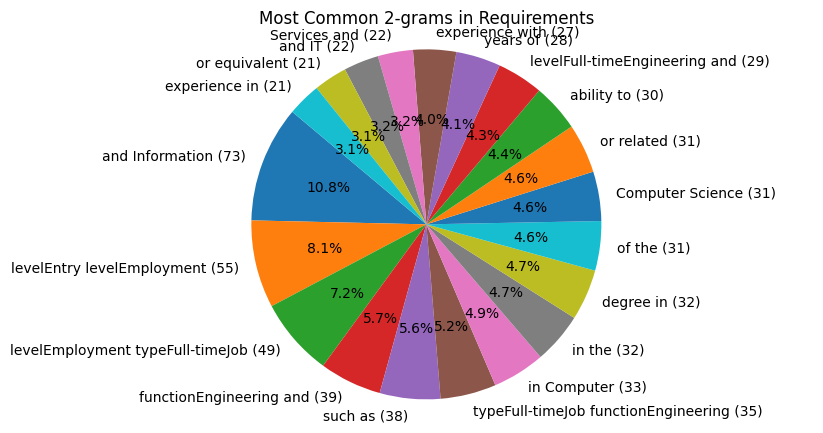

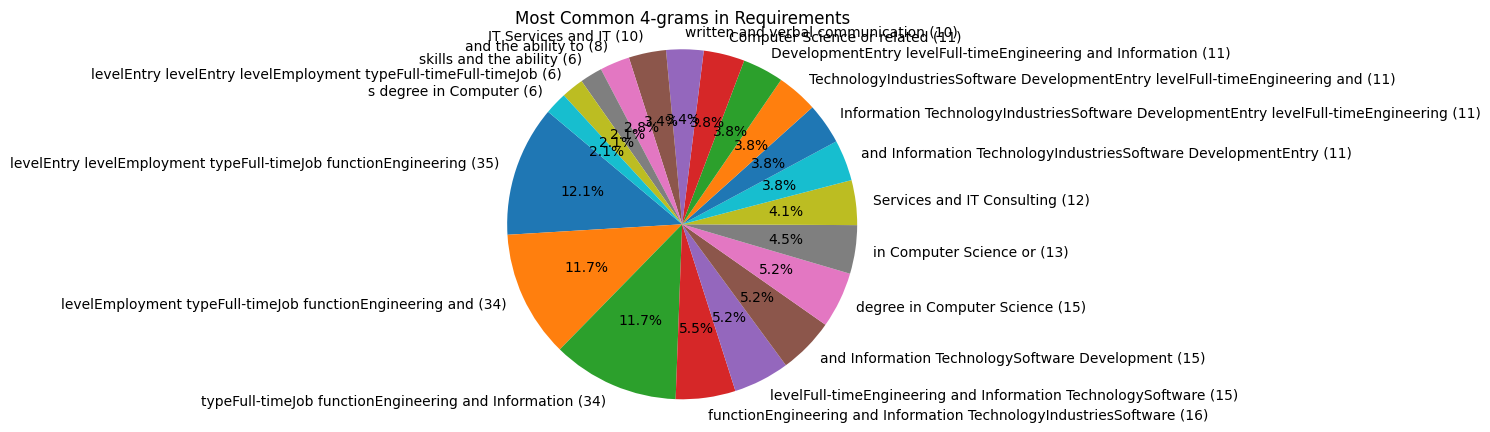

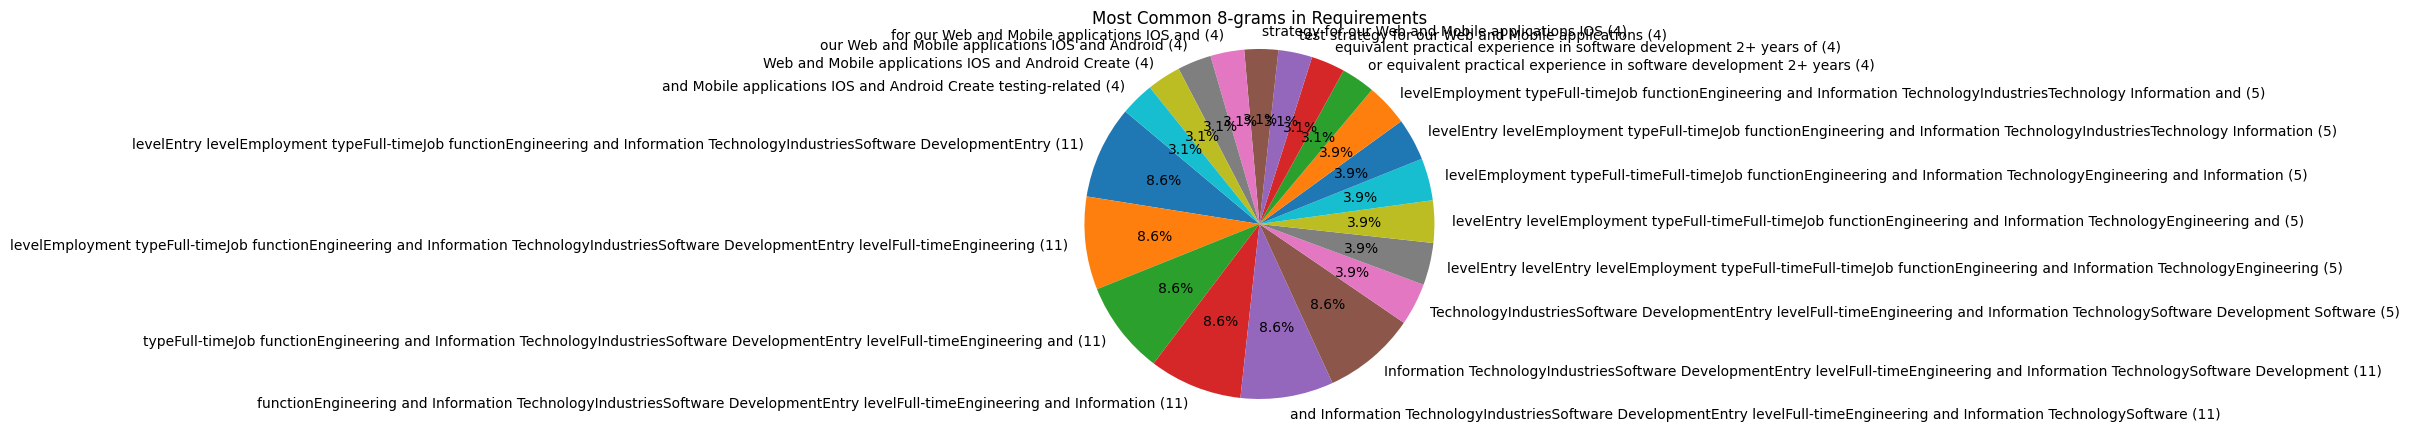

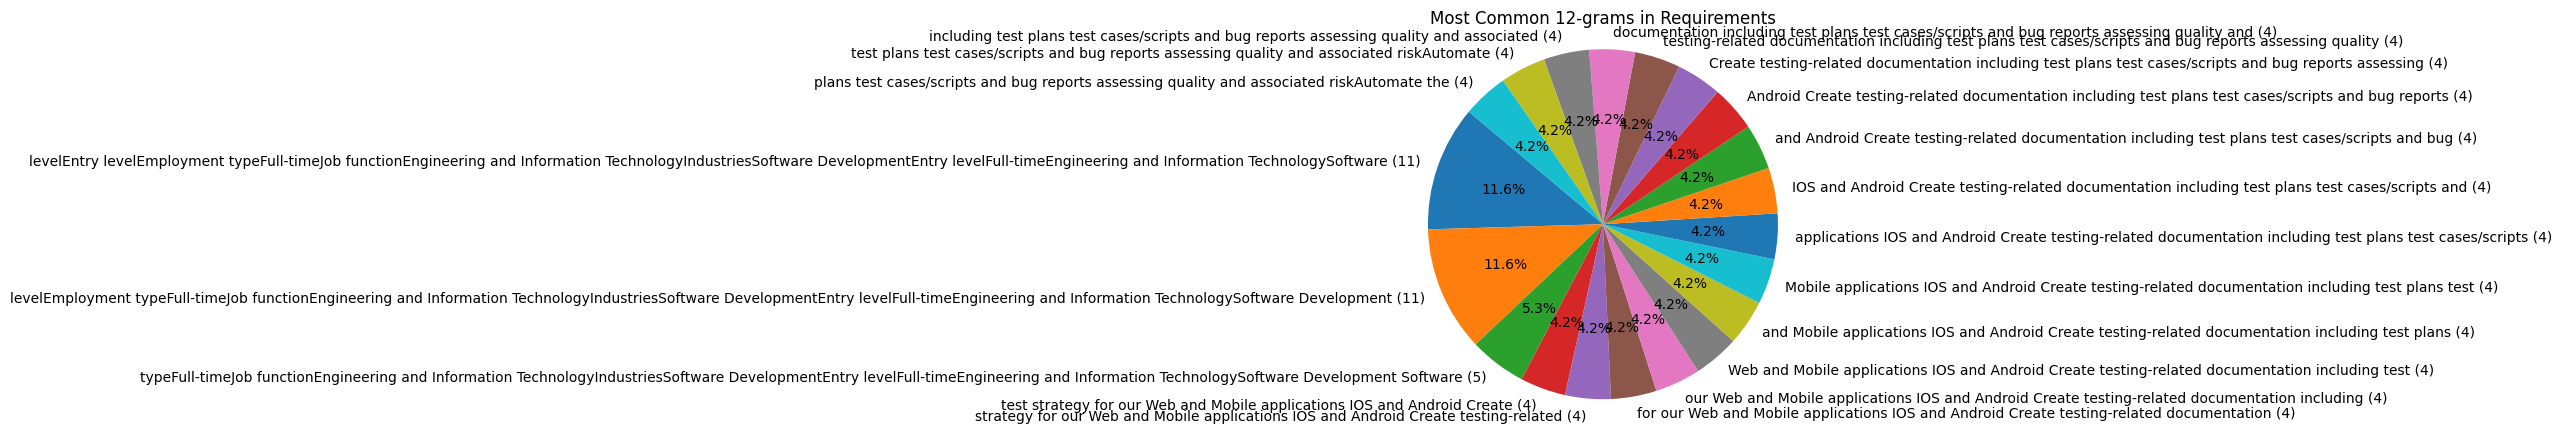

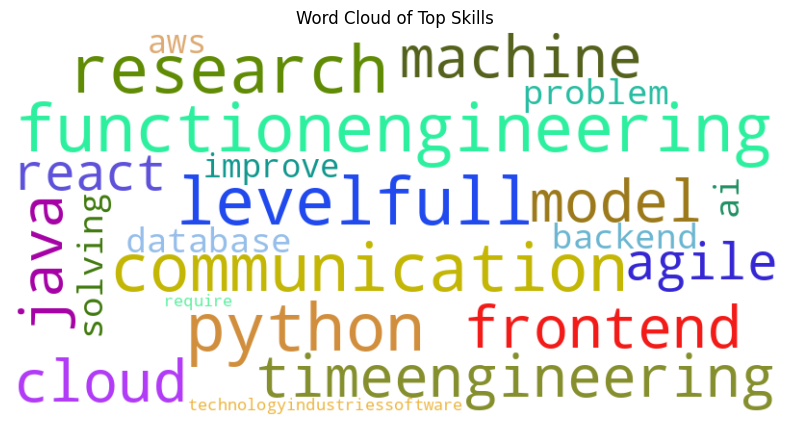

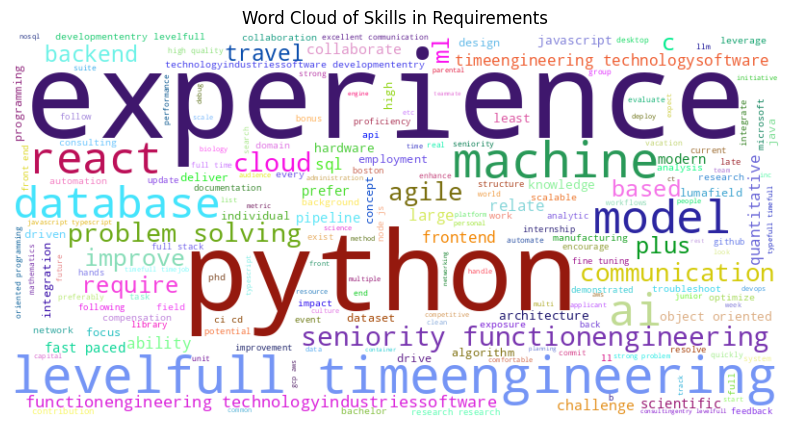

In [39]:


# Global list to store top most frequent tokens
top_skills = []

# Function to read requirements from the file
# Modified to read from a DataFrame instead
def read_requirements(df):
    data = df['Requirements'].str.cat()
    return '\n'.join(data.split("\n__________________________________________________\n"))

# Function to combine similar words
def combine_similar_words(tokens, word1, word2):
    combined_tokens = []
    for token in tokens:
        if token == word1 or token == word2:
            combined_tokens.append(word1)
        else:
            combined_tokens.append(token)
    return combined_tokens

# Frequency Analysis
def frequency_analysis(tokens, num_top, pdf):
    combined_tokens = combine_similar_words(tokens, 'frontend', 'front-end')
    combined_tokens = combine_similar_words(combined_tokens, 'backend', 'back-end')
    combined_tokens = combine_similar_words(combined_tokens, 'apis', 'api')
    combined_tokens = combine_similar_words(combined_tokens, 'windows', 'window')
    combined_tokens = combine_similar_words(combined_tokens, 'analysis', 'analyze')
    combined_tokens = combine_similar_words(combined_tokens, 'analysis', 'analytics')
    combined_tokens = combine_similar_words(combined_tokens, 'reporting', 'report')
    combined_tokens = combine_similar_words(combined_tokens, 'communication', 'communicate')

    frequency = Counter(combined_tokens)
    most_common = frequency.most_common(num_top)
    words, counts = zip(*most_common)

    global top_skills
    # Store the top most frequent tokens in the global list
    top_skills = list(words)

    # Bar Graph
    plt.figure(figsize=(12, 6))
    plt.bar(words, counts)
    plt.xlabel('Skills')
    plt.ylabel('Frequency')
    plt.title('Most Common Skills in Requirements')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(pdf, format='pdf')
    plt.show()


    # Pie Chart
    plt.figure(figsize=(10, 5))
    plt.pie(counts, labels=[f'{word} ({count})' for word, count in zip(words, counts)], autopct='%1.1f%%',
            startangle=140)
    plt.axis('equal')
    plt.title('Most Common Skills in Requirements')
    plt.savefig(pdf, format='pdf')
    plt.show()

# Custom color function for word clouds
def random_color_func(word=None, font_size=None, position=None, orientation=None, random_state=None, **kwargs):
    return "hsl({}, {}%, {}%)".format(random.randint(0, 360), random.randint(50, 100), random.randint(25, 75))

# Word Cloud
def generate_word_cloud(text, title, pdf):
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=random_color_func).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.savefig(pdf, format='pdf')
    plt.show()

# N-gram Analysis
def ngram_analysis(tokens, n, num_top, pdf):
    n_grams = ngrams(tokens, n)
    ngram_frequency = Counter(n_grams)
    most_common = ngram_frequency.most_common(num_top)
    ngrams_list, counts = zip(*most_common)
    ngrams_labels = [' '.join(ngram) for ngram in ngrams_list]

    # Pie Chart for N-grams
    plt.figure(figsize=(10, 5))
    plt.pie(counts, labels=[f'{label} ({count})' for label, count in zip(ngrams_labels, counts)], autopct='%1.1f%%',
            startangle=140)
    plt.axis('equal')
    plt.title(f'Most Common {n}-grams in Requirements')
    plt.savefig(pdf, format='pdf')
    plt.show()

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return 'a' # Adjective
    elif tag.startswith('V'):
        return 'v' # Verb
    elif tag.startswith('N'):
        return 'n' # Noun
    elif tag.startswith('R'):
        return 'r' # Adverb
    else:
        return None # Default to noun if not found

# Analyze Data
def analyze_data(name_file, df):

    # Load requirements from the DataFrame
    # Combine all requirements into a single string
    all_requirements_combined = read_requirements(df)

    # Tokenize the combined text
    tokens = word_tokenize(all_requirements_combined)

    # Lemmatization and remove purely numeric tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = []
    pos_tags = nltk.pos_tag(tokens)
    for word, tag in pos_tags:
        wordnet_tag = get_wordnet_pos(tag)
        if wordnet_tag is None:
            # If no specific tag is found, lemmatize without a tag (defaults to noun)
            lemma = lemmatizer.lemmatize(word.lower())
        else:
            lemma = lemmatizer.lemmatize(word.lower(), wordnet_tag)
        if not lemma.isdigit():
            lemmatized_tokens.append(lemma)

    # Define custom words to remove
    custom_stop_words = set([
        "year", "years", "work", "using", "new", "understand", "understanding", "experience",
        "knowledge", "skills", "ability", "must", "have", "with", "the", "and", "or", "to", "a", "in", "of", "for", "on", "as", "is", "are",
        "software", "development", "technology", "strong", "design", "business", "computer",
        "project", "engineering", "technical", "system", "application", "degree", "related", "environment", "solution",
        "preferred", "data", "problem", "excellent", "plus", "practice", "process", "working", "including", "tool", "written",
        "skill", "team", "support", "science", "life", "basic", "best", "within", "security", "required", "approach",
        "familiarity", "equivalent", "learn", "industry", "build", "role", "service", "field",
        "academic", "cumulative", "gpa", "company", "government", "agency", "perform",
        "tech", "technology", "companies", "clients", "skillstorm", "built", "paid", "government", "agencies", "enterprise",
        "oriented", "user", "company", "requirement", "professional",
        "management", "information", "cycle", "proficiency", "methodology", "verbal", "proficient", "one", "platform",
        "office", "developing",  "use", "level", "training", "partner", "effective",
        "position", "equal", "greater", "open", "language",
        "procedure", "delivery", "general", "issue", "and/or", "'s", "2+", "hands-on", "etc.", "on-site", "framework",
        "coding", "time", "ii", "configuration", "product", "scripting",
        "provide", "production", "implement", "code", "vision", "stack", "person", "complex", "well", "result", "need", "analytical",
        "perform", "career", "contribute", "selected", "perform", "demonstrate", "develop", "desire",
        "previous", "pattern", "performs", "demonstrated", "effectively","salary",
        "benefit", "etc", "combination", "similar", "developer", "end", "expertise",
        "like", "good", "core", "spring", "slack", "e.g.", "highly", "learning", "performance", "deployment", "boot", "building",
        "client", "candidate", "job", "feature", "remote", "program", "quality",
        "insurance", "get", "engineer", "master", "opportunity", "across", "interview",
        "employee", "please", "take", "u", "review", "flexible" ,"closely", "medical", "email",
        "manager", "maintain", "synergisticit", "electrical", "minimum", "help", "infrastructure",
        "qualification", "leave", "participate", "supporting", "based", "startup", "comprehensive",
        "world", "continuously", "make", "share","growth", "ownership",
        "implementation", "mobile", "looking", "existing", "web", "also", "creating", "per",
        "jobseekers", "customer", "someone", "love", "important", "helped", "care",
        "fully", "know", "market", "assist", "test", "status", "eligible", "ensure", "may", "area", "vehicle",
        "company-paid", "history", "change", "part", "standard", "meet", "u.s.", "plan", "appropriate","success",
        "assigned", "specification", "document", "health", "apply", "schedule",
        "education", "create", "clearance", "without", "stakeholder", "pay", "functional", "relevant",
        "task", "collaborative","hour","united","duty", "relocation", "sponsorship", "state",
        "control", "manage", "dental" ,"organization", "scope", "day", "ensuring", "visa",
        "excellence","specific", "solve", "lead", "keep", "detail", "identify", "continuous","power",
        "global", "internal", "member", "able", "request" , "various", "operational", "attention",
        "disability", "responsibility", "operation", "policy", "necessary" , "conduct", "workflow" ,
        "department", "operating", "employer", "location", "external", "source", "etl",
        "offer", "levelentry", "levelemployment", "typefull-timejob", "principle","include","write",
        "range","base"
    ])

    # Remove stopwords and custom words
    stop_words = set(stopwords.words('english'))
    all_stop_words = stop_words.union(custom_stop_words)

    # Filter tokens: keep words with at least one alphanumeric character and not in stopwords
    filtered_tokens = [word for word in lemmatized_tokens if word not in all_stop_words and re.search(r'\w', word)]

    # Removing periods, commas, "'s", and single character words
    # less_filtered_tokens = [re.sub(r"\'s", '', re.sub(r'[.,]', '', word)) for word in tokens if len(word) > 1]
    less_filtered_tokens = []
    for word in tokens:
        if len(word) > 1:
            word_without_punctuation = re.sub(r'[.,]', ' ', word)
            cleaned_word = re.sub(r"\'", '', word_without_punctuation)
            less_filtered_tokens.append(cleaned_word)

    # Save all plots to a single PDF file
    with PdfPages(name_file + '_analysis.pdf') as pdf:
        frequency_analysis(filtered_tokens, 20, pdf)
        ngram_analysis(less_filtered_tokens, 2, 20, pdf)
        ngram_analysis(less_filtered_tokens, 4, 20, pdf)
        ngram_analysis(less_filtered_tokens, 8, 20, pdf)
        ngram_analysis(less_filtered_tokens, 12, 20, pdf)
        generate_word_cloud(' '.join(top_skills), 'Word Cloud of Top Skills', pdf)
        generate_word_cloud(' '.join(filtered_tokens), 'Word Cloud of Skills in Requirements', pdf)


df = pd.read_csv(name_files+'.csv')
analyze_data(name_files, df)

Successfully loaded data from 80.csv


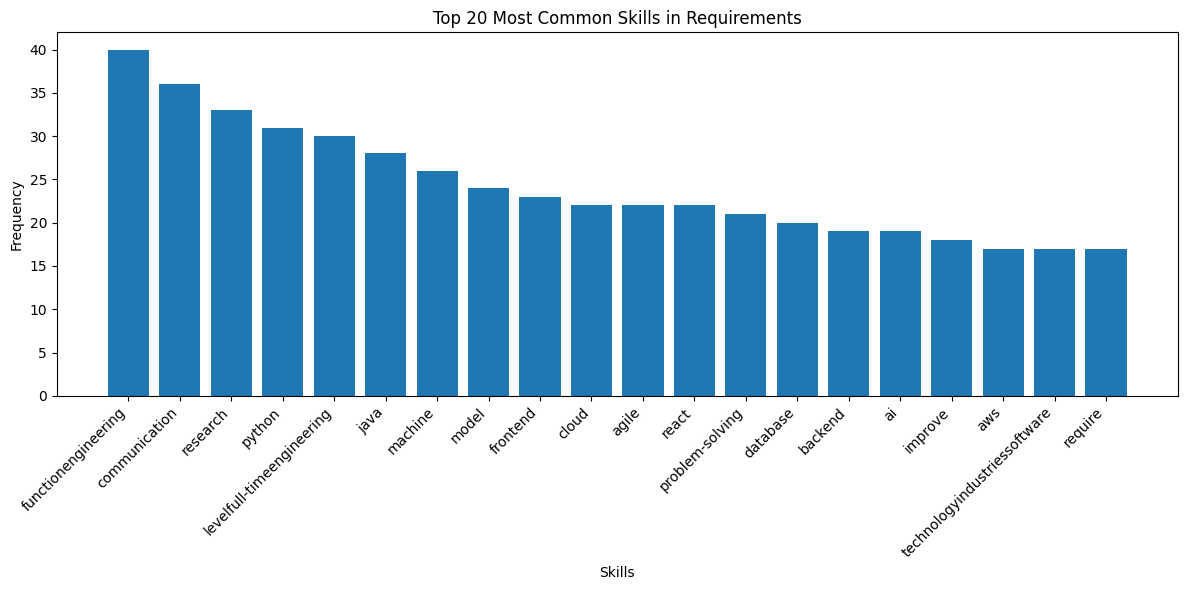

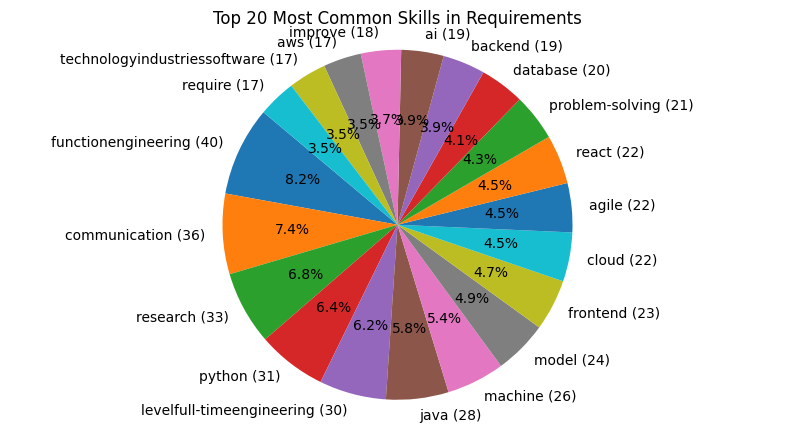

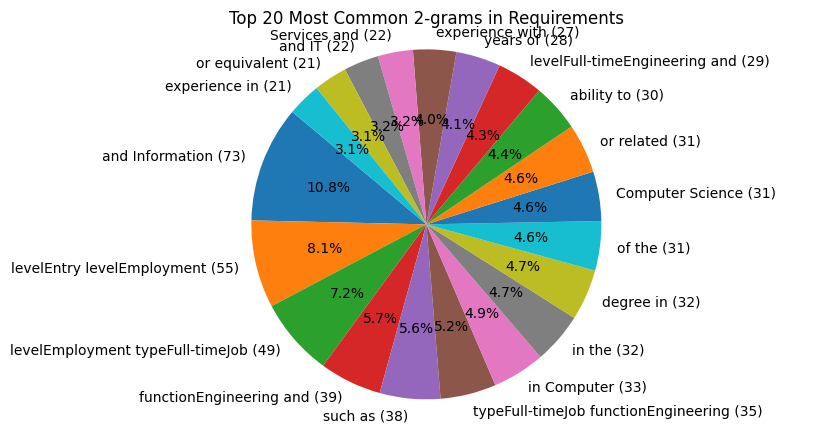

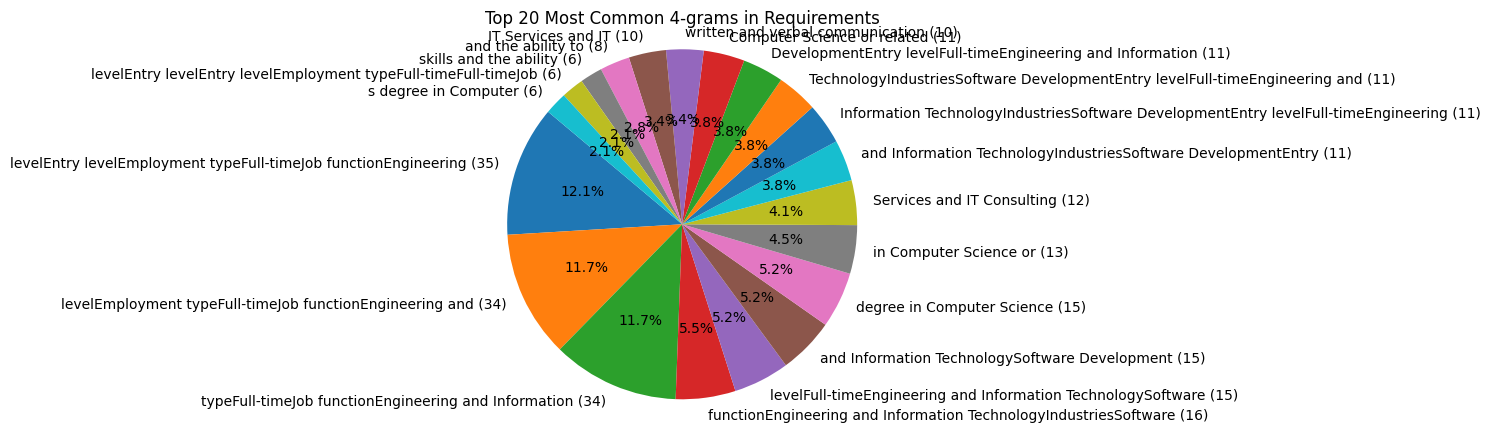

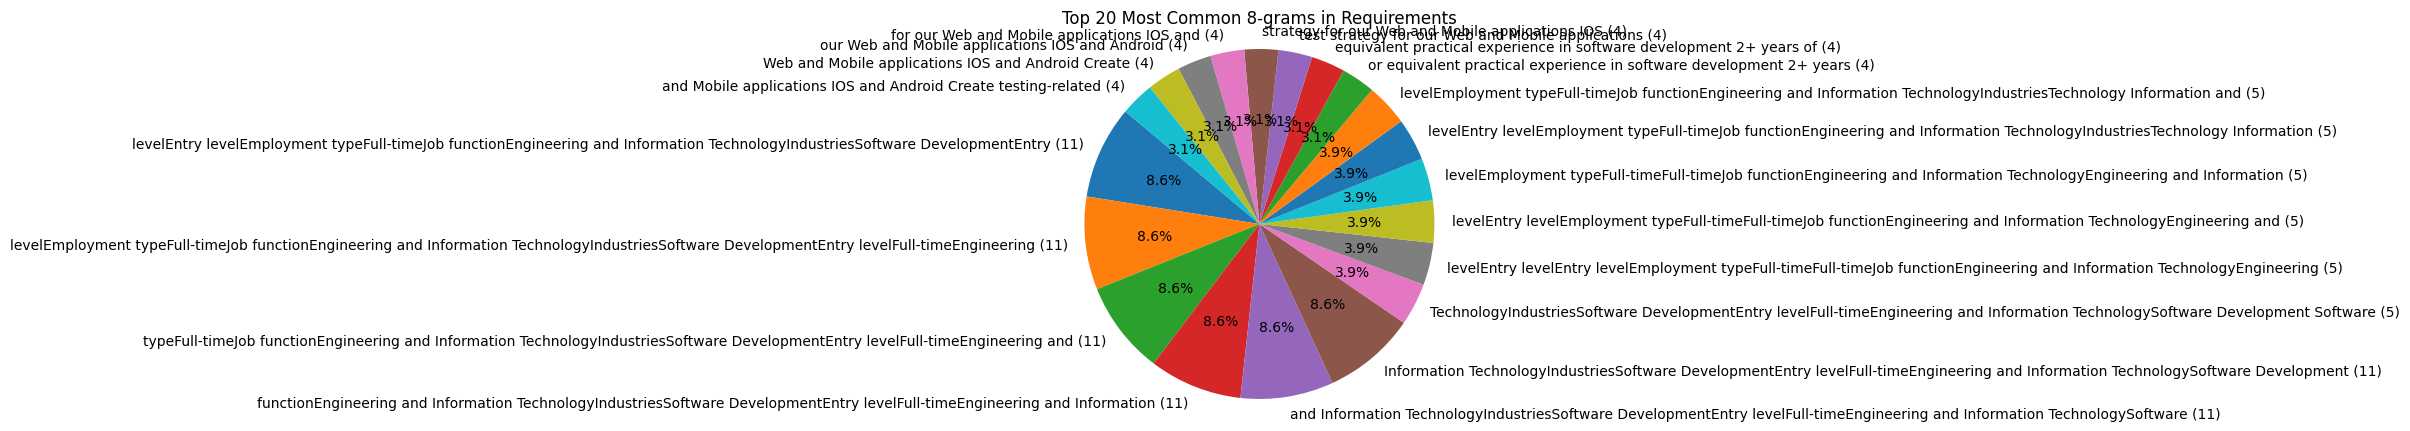

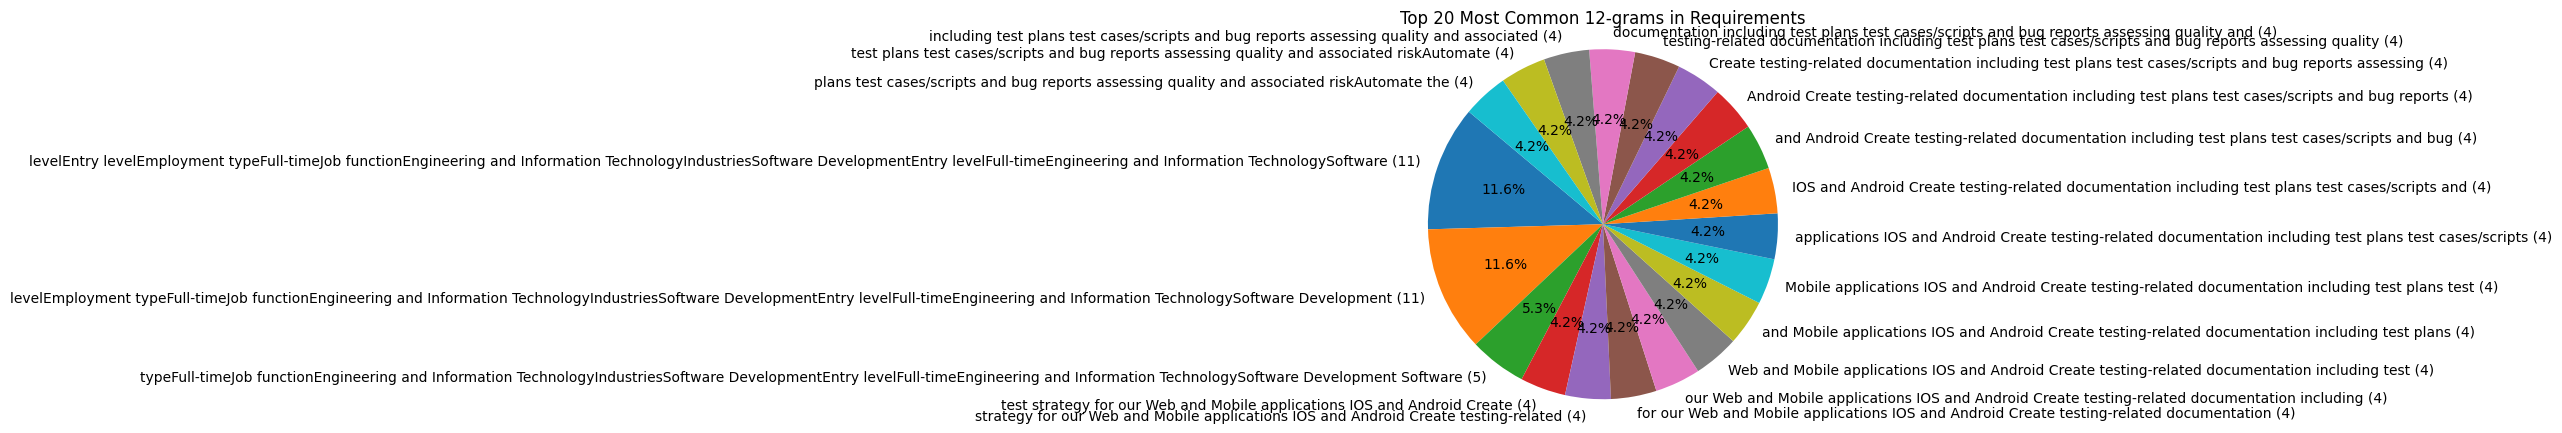

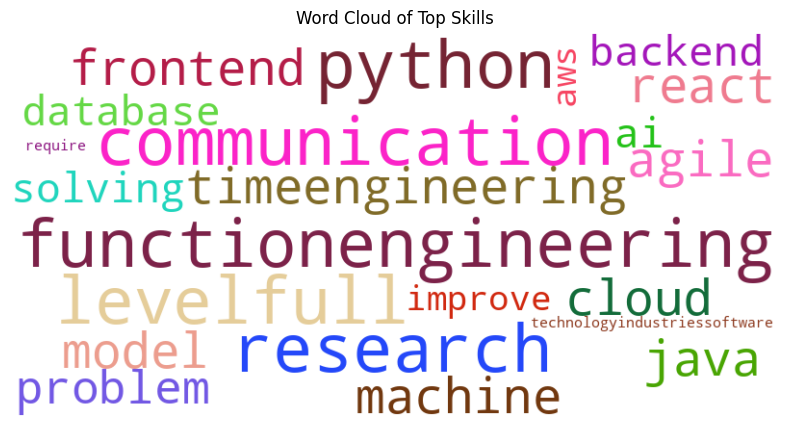

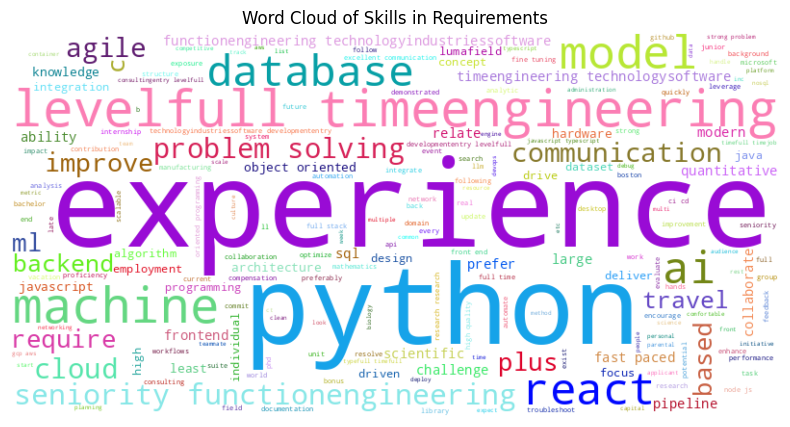

Analysis complete. Plots saved to 80_analysis.pdf


In [41]:
# Global list to store top most frequent tokens
top_skills = []

# Function to read requirements from the file
# Modified to read from a DataFrame instead
def read_requirements(df):
    """
    Combines the 'Requirements' column from a DataFrame into a single string.

    Args:
        df (pd.DataFrame): The DataFrame containing job data with a 'Requirements' column.

    Returns:
        str: A single string containing all combined requirements.
    """
    data = df['Requirements'].str.cat()
    return '\n'.join(data.split("\n__________________________________________________\n"))

# Function to combine similar words
def combine_similar_words(tokens, word1, word2):
    """
    Replaces occurrences of word2 with word1 in a list of tokens.

    Args:
        tokens (list): A list of words (tokens).
        word1 (str): The word to replace with.
        word2 (str): The word to be replaced.

    Returns:
        list: A new list of tokens with replacements.
    """
    combined_tokens = []
    for token in tokens:
        if token == word1 or token == word2:
            combined_tokens.append(word1)
        else:
            combined_tokens.append(token)
    return combined_tokens

# Frequency Analysis
def frequency_analysis(tokens, num_top, pdf):
    """
    Performs frequency analysis on tokens, generates bar and pie charts,
    and updates the global top_skills list.

    Args:
        tokens (list): A list of tokens for analysis.
        num_top (int): The number of top frequent items to display.
        pdf (PdfPages): The PDF object to save plots to.
    """
    # Combine similar words to normalize frequency counts
    combined_tokens = combine_similar_words(tokens, 'frontend', 'front-end')
    combined_tokens = combine_similar_words(combined_tokens, 'backend', 'back-end')
    combined_tokens = combine_similar_words(combined_tokens, 'apis', 'api')
    combined_tokens = combine_similar_words(combined_tokens, 'windows', 'window')
    combined_tokens = combine_similar_words(combined_tokens, 'analysis', 'analyze')
    combined_tokens = combine_similar_words(combined_tokens, 'analysis', 'analytics')
    combined_tokens = combine_similar_words(combined_tokens, 'reporting', 'report')
    combined_tokens = combine_similar_words(combined_tokens, 'communication', 'communicate')

    # Count the frequency of each token
    frequency = Counter(combined_tokens)
    # Get the most common tokens
    most_common = frequency.most_common(num_top)
    words, counts = zip(*most_common)

    global top_skills
    # Store the top most frequent tokens in the global list
    top_skills = list(words)

    # Generate and save Bar Graph
    plt.figure(figsize=(12, 6))
    plt.bar(words, counts)
    plt.xlabel('Skills')
    plt.ylabel('Frequency')
    plt.title(f'Top {num_top} Most Common Skills in Requirements')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    pdf.savefig()  # Save the current figure to the PDF
    plt.show()


    # Generate and save Pie Chart
    plt.figure(figsize=(10, 5))
    plt.pie(counts, labels=[f'{word} ({count})' for word, count in zip(words, counts)], autopct='%1.1f%%',
            startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(f'Top {num_top} Most Common Skills in Requirements')
    pdf.savefig()  # Save the current figure to the PDF
    plt.show()

# Custom color function for word clouds
def random_color_func(word=None, font_size=None, position=None, orientation=None, random_state=None, **kwargs):
    """Generates a random HSL color."""
    return "hsl({}, {}%, {}%)".format(random.randint(0, 360), random.randint(50, 100), random.randint(25, 75))

# Word Cloud
def generate_word_cloud(text, title, pdf):
    """
    Generates a word cloud from the given text and saves it to a PDF.

    Args:
        text (str): The text to generate the word cloud from.
        title (str): The title for the word cloud plot.
        pdf (PdfPages): The PDF object to save the plot to.
    """
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=random_color_func).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off') # Hide axes
    plt.title(title)
    pdf.savefig()  # Save the current figure to the PDF
    plt.show()

# N-gram Analysis
def ngram_analysis(tokens, n, num_top, pdf):
    """
    Performs N-gram analysis, generates a pie chart, and saves it to a PDF.

    Args:
        tokens (list): A list of tokens for N-gram analysis.
        n (int): The size of the N-grams.
        num_top (int): The number of top N-grams to display.
        pdf (PdfPages): The PDF object to save the plot to.
    """
    # Generate N-grams
    n_grams = ngrams(tokens, n)
    # Count the frequency of each N-gram
    ngram_frequency = Counter(n_grams)
    # Get the most common N-grams
    most_common = ngram_frequency.most_common(num_top)

    if not most_common:
        print(f"No {n}-grams found to analyze.")
        return

    ngrams_list, counts = zip(*most_common)
    # Create labels for the pie chart
    ngrams_labels = [' '.join(ngram) for ngram in ngrams_list]

    # Generate and save Pie Chart for N-grams
    plt.figure(figsize=(10, 5))
    plt.pie(counts, labels=[f'{label} ({count})' for label, count in zip(ngrams_labels, counts)], autopct='%1.1f%%',
            startangle=140)
    plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(f'Top {num_top} Most Common {n}-grams in Requirements')
    pdf.savefig()  # Save the current figure to the PDF
    plt.show()

def get_wordnet_pos(tag):
    """
    Maps an NLTK part-of-speech tag to a WordNet part-of-speech tag.

    Args:
        tag (str): The NLTK part-of-speech tag.

    Returns:
        str or None: The corresponding WordNet tag ('a', 'v', 'n', 'r') or None.
    """
    if tag.startswith('J'):
        return 'a' # Adjective
    elif tag.startswith('V'):
        return 'v' # Verb
    elif tag.startswith('N'):
        return 'n' # Noun
    elif tag.startswith('R'):
        return 'r' # Adverb
    else:
        return None # Default to noun if not found

# Analyze Data
def analyze_data(name_file, df):
    """
    Analyzes job requirements from a DataFrame and generates visualizations.

    Args:
        name_file (str): The base name for output files.
        df (pd.DataFrame): The DataFrame containing job data with a 'Requirements' column.
    """
    if df.empty:
        print("DataFrame is empty. No data to analyze.")
        return

    # Load requirements from the DataFrame
    # Combine all requirements into a single string
    all_requirements_combined = read_requirements(df)

    if not all_requirements_combined.strip():
        print("No requirements found in the data for analysis.")
        return

    # Tokenize the combined text
    tokens = word_tokenize(all_requirements_combined)

    # Lemmatization and remove purely numeric tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = []
    pos_tags = nltk.pos_tag(tokens)
    for word, tag in pos_tags:
        wordnet_tag = get_wordnet_pos(tag)
        if wordnet_tag is None:
            # If no specific tag is found, lemmatize without a tag (defaults to noun)
            lemma = lemmatizer.lemmatize(word.lower())
        else:
            lemma = lemmatizer.lemmatize(word.lower(), wordnet_tag)
        if not lemma.isdigit():
            lemmatized_tokens.append(lemma)

    # Define custom words to remove
    custom_stop_words = set([
        "year", "years", "work", "using", "new", "understand", "understanding", "experience",
        "knowledge", "skills", "ability", "must", "have", "with", "the", "and", "or", "to", "a", "in", "of", "for", "on", "as", "is", "are",
        "software", "development", "technology", "strong", "design", "business", "computer",
        "project", "engineering", "technical", "system", "application", "degree", "related", "environment", "solution",
        "preferred", "data", "problem", "excellent", "plus", "practice", "process", "working", "including", "tool", "written",
        "skill", "team", "support", "science", "life", "basic", "best", "within", "security", "required", "approach",
        "familiarity", "equivalent", "learn", "industry", "build", "role", "service", "field",
        "academic", "cumulative", "gpa", "company", "government", "agency", "perform",
        "tech", "technology", "companies", "clients", "skillstorm", "built", "paid", "government", "agencies", "enterprise",
        "oriented", "user", "company", "requirement", "professional",
        "management", "information", "cycle", "proficiency", "methodology", "verbal", "proficient", "one", "platform",
        "office", "developing",  "use", "level", "training", "partner", "effective",
        "position", "equal", "greater", "open", "language",
        "procedure", "delivery", "general", "issue", "and/or", "'s", "2+", "hands-on", "etc.", "on-site", "framework",
        "coding", "time", "ii", "configuration", "product", "scripting",
        "provide", "production", "implement", "code", "vision", "stack", "person", "complex", "well", "result", "need", "analytical",
        "perform", "career", "contribute", "selected", "perform", "demonstrate", "develop", "desire",
        "previous", "pattern", "performs", "demonstrated", "effectively","salary",
        "benefit", "etc", "combination", "similar", "developer", "end", "expertise",
        "like", "good", "core", "spring", "slack", "e.g.", "highly", "learning", "performance", "deployment", "boot", "building",
        "client", "candidate", "job", "feature", "remote", "program", "quality",
        "insurance", "get", "engineer", "master", "opportunity", "across", "interview",
        "employee", "please", "take", "u", "review", "flexible" ,"closely", "medical", "email",
        "manager", "maintain", "synergisticit", "electrical", "minimum", "help", "infrastructure",
        "qualification", "leave", "participate", "supporting", "based", "startup", "comprehensive",
        "world", "continuously", "make", "share","growth", "ownership",
        "implementation", "mobile", "looking", "existing", "web", "also", "creating", "per",
        "jobseekers", "customer", "someone", "love", "important", "helped", "care",
        "fully", "know", "market", "assist", "test", "status", "eligible", "ensure", "may", "area", "vehicle",
        "company-paid", "history", "change", "part", "standard", "meet", "u.s.", "plan", "appropriate","success",
        "assigned", "specification", "document", "health", "apply", "schedule",
        "education", "create", "clearance", "without", "stakeholder", "pay", "functional", "relevant",
        "task", "collaborative","hour","united","duty", "relocation", "sponsorship", "state",
        "control", "manage", "dental" ,"organization", "scope", "day", "ensuring", "visa",
        "excellence","specific", "solve", "lead", "keep", "detail", "identify", "continuous","power",
        "global", "internal", "member", "able", "request" , "various", "operational", "attention",
        "disability", "responsibility", "operation", "policy", "necessary" , "conduct", "workflow" ,
        "department", "operating", "employer", "location", "external", "source", "etl",
        "offer", "levelentry", "levelemployment", "typefull-timejob", "principle","include","write",
        "range","base"
    ])

    # Remove stopwords and custom words
    stop_words = set(stopwords.words('english'))
    all_stop_words = stop_words.union(custom_stop_words)

    # Filter tokens: keep words with at least one alphanumeric character and not in stopwords
    filtered_tokens = [word for word in lemmatized_tokens if word not in all_stop_words and re.search(r'\w', word)]

    # Removing periods, commas, "'s", and single character words
    less_filtered_tokens = []
    for word in tokens:
        if len(word) > 1:
            word_without_punctuation = re.sub(r'[.,]', ' ', word)
            cleaned_word = re.sub(r"\'", '', word_without_punctuation)
            less_filtered_tokens.append(cleaned_word)

    # Save all plots to a single PDF file
    try:
        with PdfPages(name_file + '_analysis.pdf') as pdf:
            frequency_analysis(filtered_tokens, 20, pdf)
            ngram_analysis(less_filtered_tokens, 2, 20, pdf)
            ngram_analysis(less_filtered_tokens, 4, 20, pdf)
            ngram_analysis(less_filtered_tokens, 8, 20, pdf)
            ngram_analysis(less_filtered_tokens, 12, 20, pdf)
            generate_word_cloud(' '.join(top_skills), 'Word Cloud of Top Skills', pdf)
            generate_word_cloud(' '.join(filtered_tokens), 'Word Cloud of Skills in Requirements', pdf)
        print(f"Analysis complete. Plots saved to {name_file}_analysis.pdf")
    except Exception as e:
        print(f"An error occurred during plot generation or saving: {e}")


# Load data from the CSV file
try:
    df = pd.read_csv(name_files+'.csv')
    print(f"Successfully loaded data from {name_files}.csv")
    # Perform data analysis
    analyze_data(name_files, df)
except FileNotFoundError:
    print(f"Error: The file {name_files}.csv was not found. Please ensure the scraping step completed successfully.")
except pd.errors.EmptyDataError:
    print(f"Error: The file {name_files}.csv is empty. No data to analyze.")
except Exception as e:
    print(f"An unexpected error occurred while loading or analyzing the data: {e}")